This project explores a mock dataset of stars, constellations, galaxies, and users. It demonstrates how I approach data analysis: cleaning, descriptive stats, inferential tests, and visualization — even in a science-inspired domain. Unlike my other projects, this project is focused on **statistics and analytical depth**.

This notebook focuses on **user behavior analysis**.  After analyzing the astronomy data in previous notebooks,
we now turn to the people behind the data.

First, import the necessary libraries and load the CSVs into dataframes.  Note that the CSVs that have already been cleaned up by `01_raw_data_cleanup.ipynb` are loaded.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


SOURCE_FOLDER = "../data/cleaned"
sns.set_theme(style="whitegrid", palette="deep")

df_stars = pd.read_csv(f"{SOURCE_FOLDER}/stars.csv")
df_constellations = pd.read_csv(f"{SOURCE_FOLDER}/constellations.csv")
df_galaxies = pd.read_csv(f"{SOURCE_FOLDER}/galaxies.csv")
df_users = pd.read_csv(f"{SOURCE_FOLDER}/users.csv")

First, link stars to their `added_by` and `verified_by` users so we can examine who contributes and who verifies.

In [2]:
stars_with_users = (
    df_stars
    .merge(df_users.add_prefix("adder_"), left_on="added_by", right_on="adder_user_id")
    .merge(df_users.add_prefix("verifier_"), left_on="verified_by", right_on="verifier_user_id")
)

stars_with_users[[
    "star_id", "star_name", "adder_username", "adder_date_of_birth",
    "verifier_username", "verifier_date_of_birth"
]].head()

,star_id,star_name,adder_username,adder_date_of_birth,verifier_username,verifier_date_of_birth
0,1,Star-00001,quinncooper,2001-10-25,leereyes,1991-03-21
1,2,Star-00002,reesegonzalez,2002-09-04,noahali,1989-08-20
2,3,Star-00003,jamiechen,1996-10-28,maxcook,1987-12-11
3,4,Star-00004,aaronbailey,1997-10-13,averyramos,1985-12-13
4,5,Star-00005,chrisramos,2001-09-15,averyramos,1985-12-13


When we eyeball the first rows, it seems that *adders* are consistently younger than *verifiers*.  To test this, we calculate ages and plot distributions.

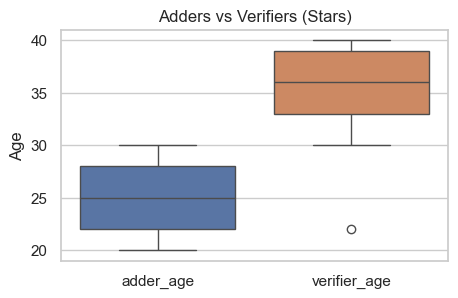

In [3]:
# compute ages
today_year = pd.to_datetime("today").year
stars_with_users["adder_age"] = today_year - pd.to_datetime(stars_with_users["adder_date_of_birth"]).dt.year
stars_with_users["verifier_age"] = today_year - pd.to_datetime(stars_with_users["verifier_date_of_birth"]).dt.year

plt.figure(figsize=(5, 3))
sns.boxplot(data=stars_with_users[["adder_age", "verifier_age"]])
plt.title("Adders vs Verifiers (Stars)")
plt.ylabel("Age")
plt.show()

The boxplot above shows age distributions for adders and verifiers in the **stars** dataset:

- Adders fall mostly in their 20s.  
- Verifiers fall mostly in their 30s.  
- There is an outlier verifier around age 22.  

Already we see a general split in responsibilities: younger users add, older users verify.

To confirm whether this pattern holds across other datasets, we combine **stars**, **constellations** and **galaxies**.

In [4]:
df_stars_trimmed = df_stars[["star_id", "star_name", "added_by", "verified_by"]
                            ].rename(columns={"star_id": "id", "star_name": "name"})
df_stars_trimmed.insert(0, "type", "Star")

df_constellations_trimmed = df_constellations[["constellation_id", "constellation_name", "added_by", "verified_by"]
                            ].rename(columns={"constellation_id": "id", "constellation_name": "name"})
df_constellations_trimmed.insert(0, "type", "Constellation")

df_galaxies_trimmed = df_galaxies[["galaxy_id", "galaxy_name", "added_by", "verified_by"]
                            ].rename(columns={"galaxy_id": "id", "galaxy_name": "name"})
df_galaxies_trimmed.insert(0, "type", "Galaxy")

df_combined = pd.concat([df_stars_trimmed, df_constellations_trimmed, df_galaxies_trimmed])
df_combined = (
    df_combined
    .merge(df_users.add_prefix("adder_"), left_on="added_by", right_on="adder_user_id")
    .merge(df_users.add_prefix("verifier_"), left_on="verified_by", right_on="verifier_user_id")
)
display(df_combined[df_combined["id"] == 1])


,type,id,name,added_by,verified_by,adder_user_id,adder_username,adder_email,adder_password,adder_first_name,adder_last_name,adder_date_of_birth,verifier_user_id,verifier_username,verifier_email,verifier_password,verifier_first_name,verifier_last_name,verifier_date_of_birth
0,Star,1,Star-00001,89,107,89,quinncooper,quinncooper@example.com,REDACTED,Quinn,Cooper,2001-10-25,107,leereyes,leereyes@example.com,REDACTED,Lee,Reyes,1991-03-21
503,Constellation,1,Constellation-001,1,97,1,taylorkim,taylorkim@example.com,REDACTED,Taylor,Kim,1997-01-12,97,harpertorres,harpertorres@example.com,REDACTED,Harper,Torres,1991-11-07
908,Galaxy,1,Galaxy-001,23,113,23,caseyscott,caseyscott@example.com,REDACTED,Casey,Scott,2004-12-21,113,logancooper,logancooper@example.com,REDACTED,Logan,Cooper,1992-07-02


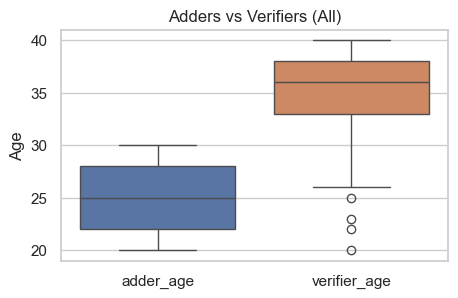

In [5]:
df_combined["adder_age"] = today_year - pd.to_datetime(df_combined["adder_date_of_birth"]).dt.year
df_combined["verifier_age"] = today_year - pd.to_datetime(df_combined["verifier_date_of_birth"]).dt.year

plt.figure(figsize=(5, 3))
sns.boxplot(data=df_combined[["adder_age", "verifier_age"]])
plt.title("Adders vs Verifiers (All)")
plt.ylabel("Age")
plt.show()

The combined boxplot again shows:
- Adders: clustered in the 20–30 range.  
- Verifiers: clustered in the 30–40 range.  
- A handful of verifiers in their early 20s show up as outliers.

We now look more closely at the records that don't conform to this pattern.

In [6]:
display(df_combined[df_combined["verifier_age"] < 30])

,type,id,name,added_by,verified_by,adder_user_id,adder_username,adder_email,adder_password,adder_first_name,...,adder_date_of_birth,verifier_user_id,verifier_username,verifier_email,verifier_password,verifier_first_name,verifier_last_name,verifier_date_of_birth,adder_age,verifier_age
502,Star,10008,Sirius,19,95,19,morgannguyen,morgannguyen@example.com,REDACTED,Morgan,...,1998-05-02,95,jamiekelly,jamiekelly@example.com,REDACTED,Jamie,Kelly,2003-10-11,27,22
903,Constellation,1001,Orion,42,88,42,zoenguyen,zoenguyen@example.com,REDACTED,Zoe,...,2003-11-16,88,chrisjames,chrisjames@example.com,REDACTED,Chris,James,2005-12-26,22,20
904,Constellation,1003,Cassiopea,39,75,39,alexpatel,alexpatel@example.com,REDACTED,Alex,...,2004-01-22,75,aaronbailey,aaronbailey@example.com,REDACTED,Aaron,Bailey,1997-10-13,21,28
906,Constellation,1010,Milky Way Test,22,77,22,averyortiz,averyortiz@example.com,REDACTED,Avery,...,1996-03-18,77,reesegonzalez,reesegonzalez@example.com,REDACTED,Reese,Gonzalez,2002-09-04,29,23
1308,Galaxy,1501,Milky Way,45,90,45,rowanbrooks,rowanbrooks@example.com,REDACTED,Rowan,...,1999-02-12,90,maxtorres,maxtorres@example.com,REDACTED,Max,Torres,2000-01-16,26,25
1309,Galaxy,1503,Andromdea,32,81,32,jordangomez,jordangomez@example.com,REDACTED,Jordan,...,1995-05-28,81,alexcooper,alexcooper@example.com,REDACTED,Alex,Cooper,1999-04-26,30,26


There are 6 records that don't align: a star with `star_id` 10008, 3 constellations with `constellation_id` 1001, 1003 and 1010, and 2 galaxies with `galaxy_id` 1501 and 1503.  I am flagging them.  Here is the reasoning:

- For **apparent magnitude**, outliers were **kept** because the *business rules* explicitly state that apparent magnitude values can range from 0 to 10.  Even if a star looks unusually bright or faint compared to the majority, as long as it falls within that range, it is considered valid data.  

- For **verifier ages**, no explicit rule exists that defines what is "valid" but the pattern shows that verifiers are consistently older than adders. A handful of verifiers break this pattern.  Because there is no business rule justifying these anomalies, they are suspicious and may be the result of inconsistent data entry or incorrect assignments.  

In a real-world project, I would **flag these records to the data owner for clarification** before continuing.  For this demo, I filter them out to keep the analysis consistent with the majority pattern observed in the dataset.

In [7]:
df_combined = df_combined[df_combined["verifier_age"] >= 30]
print(df_combined.shape)

(1305, 21)


We now redraw the **Adders vs Verifiers (All)** boxplot.

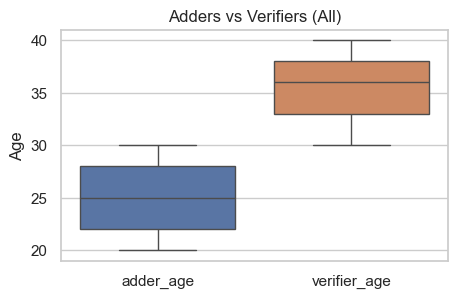

In [8]:
df_combined["adder_age"] = today_year - pd.to_datetime(df_combined["adder_date_of_birth"]).dt.year
df_combined["verifier_age"] = today_year - pd.to_datetime(df_combined["verifier_date_of_birth"]).dt.year

plt.figure(figsize=(5, 3))
sns.boxplot(data=df_combined[["adder_age", "verifier_age"]])
plt.title("Adders vs Verifiers (All)")
plt.ylabel("Age")
plt.show()

Next, we look at **how much each user contributes** — both adders and verifiers.  This helps us see if the workload is evenly distributed, or if some people carry much more of the load than others.

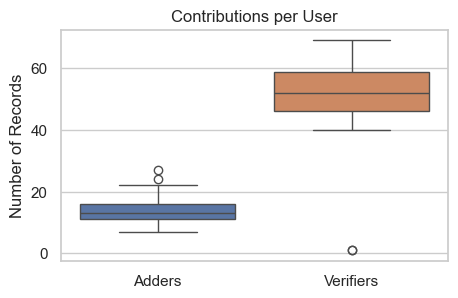

In [9]:
# Count contributions per adder and verifier
adder_counts = df_combined.groupby("adder_username").size().reset_index(name="records_added")
verifier_counts = df_combined.groupby("verifier_username").size().reset_index(name="records_verified")

# Boxplot to compare distributions
plt.figure(figsize=(5, 3))
sns.boxplot(data=[adder_counts["records_added"], verifier_counts["records_verified"]])
plt.xticks([0, 1], ["Adders", "Verifiers"])
plt.title("Contributions per User")
plt.ylabel("Number of Records")
plt.show()


The boxplot shows a clear difference:
- **Adders** typically contribute fewer records (around 10–20 each).
- **Verifiers** handle much more (around 40–60 each).

This pattern makes business sense:
- Adding requires more effort (finding and recording new entities).
- Verifying is lighter work (checking what was already added).

So we naturally expect *fewer contributions per adder* and *more verifications per verifier*.

Notice that we have verifiers who verified very few records:

In [10]:
print(verifier_counts[verifier_counts["records_verified"] < 20])

  verifier_username  records_verified
2        blakeramos                 1
5        caseyreyes                 1


There are two users with 1 verification each.  We now filter the `df_combined` dataframe for the records verified by these users.

In [11]:
display(df_combined[df_combined["verifier_username"].isin(["blakeramos", "caseyreyes"])])

,type,id,name,added_by,verified_by,adder_user_id,adder_username,adder_email,adder_password,adder_first_name,...,adder_date_of_birth,verifier_user_id,verifier_username,verifier_email,verifier_password,verifier_first_name,verifier_last_name,verifier_date_of_birth,adder_age,verifier_age
905,Constellation,1006,Centaurus,21,54,21,chriscook,chriscook@example.com,REDACTED,Chris,...,2003-04-26,54,caseyreyes,caseyreyes@example.com,REDACTED,Casey,Reyes,1995-09-15,22,30
907,Constellation,1011,Draco,30,60,30,alexcook,alexcook@example.com,REDACTED,Alex,...,1999-12-07,60,blakeramos,blakeramos@example.com,REDACTED,Blake,Ramos,1995-06-01,26,30


We see 2 constellations with `constellation_id` 1006 and 1011.  I am also flagging these records.  The reasoning is similar to my previous reasoning (i. e. to flag young verifiers):

- For **apparent magnitude**, *business rules* state that values can range from 0-10.

- For **verification counts**, no explicit rule exists that defines what is "valid" but the pattern shows that verifiers contribute 40-60 records each. Two verifiers break this pattern.  Because there is no business rule justifying these anomalies, they are suspicious and may also be the result of inconsistent data entry or incorrect assignments.  

In a real-world project, I  also **flag these records to the data owner for clarification** before continuing.  For this demo, I filter them out.

In [12]:
print(df_combined.shape)
df_combined = df_combined[~ df_combined["verifier_username"].isin(["blakeramos", "caseyreyes"])]
print(df_combined.shape)

(1305, 21)
(1303, 21)


We now redraw the **Contributions per User** boxplot.

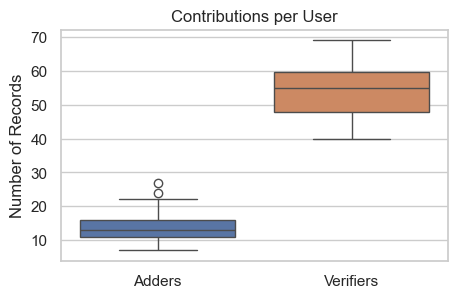

In [13]:
# Count contributions per adder and verifier
adder_counts = df_combined.groupby("adder_username").size().reset_index(name="records_added")
verifier_counts = df_combined.groupby("verifier_username").size().reset_index(name="records_verified")

# Boxplot to compare distributions
plt.figure(figsize=(5, 3))
sns.boxplot(data=[adder_counts["records_added"], verifier_counts["records_verified"]])
plt.xticks([0, 1], ["Adders", "Verifiers"])
plt.title("Contributions per User")
plt.ylabel("Number of Records")
plt.show()


### Summary

In this notebook, I analyzed **user behavior** across stars, constellations, and galaxies:

- **Age patterns:** Adders are mostly in their 20s, while verifiers are mostly in their 30s.  A few records fell outside this pattern; I flagged them as possible data issues.  

- **Contributions:** Adders contributed fewer records, while verifiers handled much more.  This aligns with the business process: adding is harder, verifying is lighter.  A few records were also inconsistent, and I also flagged them.  

- **Data quality:** When anomalies did not match any clear business rule, I flagged and removed them to keep the analysis consistent. In a real project, I would escalate these to the data owner.  

Overall, the analysis shows how to move beyond raw counts and spot **real patterns in behavior**, 
while also practicing the critical analyst skill of **distinguishing genuine outliers from data quality issues**.
